# Figure 2: Clone Dataset Overview, novel isoform expression, assay validations

In [1]:
import matplotlib as mpl
import met_brewer
import pandas as pd
import numpy as np
import seaborn as sns
import sys

from matplotlib import pyplot as plt
from scipy import stats

# import utils
sys.path.append("../")

from data_loading import (load_annotated_TFiso1_collection,
                          load_y2h_isoform_data,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_annotated_gencode_tfs,
                          load_developmental_tissue_expression_remapped,
                          load_gtex_remapped,
                          load_tf_families,
                          load_full_y2h_data_including_controls,
                          load_ref_vs_alt_isoforms_table,
                          load_PDI_luciferase_validation_experiment,
                          load_n2h_ppi_validation_data)
from plotting import mimic_r_boxplot, validation_titration_plot, validation_plot

In [2]:
PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":7,"axes.titlesize":7,
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [4]:
np.random.seed(2023)

## 1. load clone collection, gencode TFs

In [5]:
genc_tfs = load_annotated_gencode_tfs()

clone_tfs = load_annotated_TFiso1_collection()

/data/bulyk/kaia/projects/repos/tf_isoforms/cache/load_annotated_gencode_tfs.pkl
reading from cache
/data/bulyk/kaia/projects/repos/tf_isoforms/cache/load_annotated_TFiso1_collection.pkl
reading from cache


In [6]:
len(genc_tfs)

1635

In [7]:
len(clone_tfs)

309

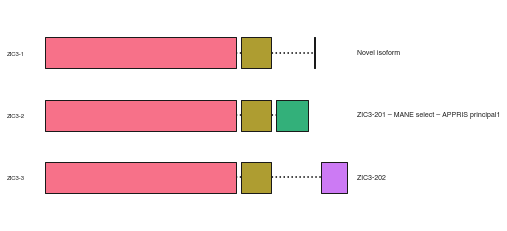

In [8]:
# check that we're using the most up-to-date clone annotations
clone_tfs['ZIC3'].exon_diagram()

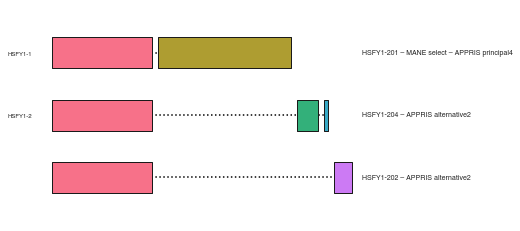

In [9]:
# check that we're using the most up-to-date clone annotations
clone_tfs['HSFY1'].exon_diagram()

## 2. count number of splicing categories across gencode and cloned TFs

In [10]:
def count_splicing_types(tfs, index):
    
    alt_n = 0
    alt_c = 0
    alt_int = 0
    alt_5ss = 0
    alt_3ss = 0
    exon_sk = 0
    mut_ex = 0
    intron_ret = 0
    tot = 0

    for tf in tfs.keys():
        gene = tfs[tf]
        if index == "gencode":
            ref = gene.reference_isoform.name
            alts = [x.name for x in gene.alternative_isoforms]
        elif index == "TFIso1.0":
            ref = gene.cloned_reference_isoform.name
            alts = [x.name for x in gene.cloned_isoforms if x.name != ref]
        elif index == "TFIso1.0 - novel":
            ref = gene.cloned_reference_isoform.name
            alts = [x.name for x in gene.cloned_isoforms if x.is_novel_isoform()]
        for alt in alts:
            splicing_cats = gene.splicing_categories(ref, alt)

            if splicing_cats['alternative N-terminal']:
                alt_n += 1
            if splicing_cats['alternative C-terminal']:
                alt_c += 1
            if splicing_cats['alternative internal exon']:
                alt_int += 1
            if splicing_cats['alternative 5\' splice site']:
                alt_5ss += 1
            if splicing_cats['alternative 3\' splice site']:
                alt_3ss += 1
            if splicing_cats['exon skipping']:
                exon_sk += 1
            if splicing_cats['mutually exclusive exons']:
                mut_ex += 1
            if splicing_cats['intron retention']:
                intron_ret += 1

            tot += 1

    df = pd.DataFrame.from_dict({"alt. N-terminal": [alt_n], "alt. C-terminal": [alt_c],
                                      "alt. internal exon": [alt_int], "alt. 5' splice site": [alt_5ss],
                                      "alt. 3' splice site": [alt_3ss], "exon skipping": [exon_sk],
                                      "mutually exclusive exons": [mut_ex], "intron retention": [intron_ret],
                                      "total": tot})
    df.index = [index]
    return df

In [11]:
genc_df = count_splicing_types(genc_tfs, "gencode")
genc_df

,alt. N-terminal,alt. C-terminal,alt. internal exon,alt. 5' splice site,alt. 3' splice site,exon skipping,mutually exclusive exons,intron retention,total
gencode,1046,1071,430,686,879,330,26,72,1855


In [12]:
clone_df = count_splicing_types(clone_tfs, "TFIso1.0")
clone_df

,alt. N-terminal,alt. C-terminal,alt. internal exon,alt. 5' splice site,alt. 3' splice site,exon skipping,mutually exclusive exons,intron retention,total
TFIso1.0,169,198,136,177,216,116,5,12,447


In [13]:
novel_df = count_splicing_types(clone_tfs, "TFIso1.0 - novel")
novel_df

,alt. N-terminal,alt. C-terminal,alt. internal exon,alt. 5' splice site,alt. 3' splice site,exon skipping,mutually exclusive exons,intron retention,total
TFIso1.0 - novel,47,68,81,69,101,69,4,5,188


In [14]:
splicing = genc_df.append(clone_df).append(novel_df)
splicing_tot = splicing["total"]
splicing = splicing.drop("total", axis=1)
splicing_perc = splicing.divide(splicing_tot, axis='rows').reset_index()
splicing_perc

,index,alt. N-terminal,alt. C-terminal,alt. internal exon,alt. 5' splice site,alt. 3' splice site,exon skipping,mutually exclusive exons,intron retention
0,gencode,0.563881,0.577358,0.231806,0.369811,0.473854,0.177898,0.014016,0.038814
1,TFIso1.0,0.378076,0.442953,0.304251,0.395973,0.483221,0.259508,0.011186,0.026846
2,TFIso1.0 - novel,0.250000,0.361702,0.430851,0.367021,0.537234,0.367021,0.021277,0.026596


In [15]:
splicing_perc_melt = pd.melt(splicing_perc, id_vars="index")

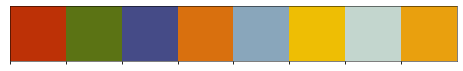

In [16]:
colors = met_brewer.met_brew(name="VanGogh2")
sns.palplot(colors)

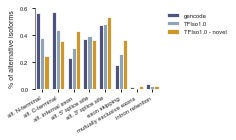

In [17]:
fig = plt.figure(figsize=(2.25, 1.5))

ax = sns.barplot(data=splicing_perc_melt, x="variable", y="value", hue="index", palette={"gencode": colors[2],
                                                                                         "TFIso1.0": colors[4],
                                                                                         "TFIso1.0 - novel": colors[7]})
ax.set_xlabel("")
ax.set_xticklabels(list(splicing_perc_melt["variable"].unique()), ha="right", va="top", rotation=30)
ax.set_ylabel("% of alternative isoforms")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig2/splicing_cats.pdf", dpi="figure", bbox_inches="tight")

## 3. expression of novel isoforms compared to annotated ref/alt

using the same dummy, downsampled data as in fig1 for consistency

In [18]:
status_map = {}

# only loop through clone collection
for tf in clone_tfs.keys():
    gene = clone_tfs[tf]
    
    try:
        annot_ref = gene.reference_isoform.name
    except:
        annot_ref = "none"
        
    try:
        annot_alt = gene.alternative_isoforms
    except:
        annot_alt = []
        
    for iso in gene.cloned_isoforms:
        if iso.name == annot_ref:
            status_map[iso.clone_acc] = {"gene_name": tf, "status": "ref"}
        elif iso.is_novel_isoform():
            status_map[iso.clone_acc] = {"gene_name": tf, "status": "novel"}
        else:
            status_map[iso.clone_acc] = {"gene_name": tf, "status": "alt"}

status_map = pd.DataFrame.from_dict(status_map, orient="index")
status_map

,gene_name,status
ZBTB18|1/2|04E08,ZBTB18,ref
ZBTB18|2/2|12E05,ZBTB18,alt
PRRX1|1/3|09C07,PRRX1,alt
PRRX1|2/3|09F06,PRRX1,ref
PRRX1|3/3|09H08,PRRX1,alt
...,...,...
HDX|2/2|09H10,HDX,novel
HSFY1|1/2|12F03,HSFY1,ref
HSFY1|2/2|11F06,HSFY1,alt
ZFY|1/2|06H10,ZFY,novel


In [19]:
status_map.status.value_counts()

alt      359
ref      209
novel    188
Name: status, dtype: int64

In [20]:
df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_remapped()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())

/data/bulyk/kaia/projects/repos/tf_isoforms/cache/load_developmental_tissue_expression_remapped.pkl
reading from cache


In [21]:
df_gtex, metadata_gtex, genes_gtex = load_gtex_remapped()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

/data/bulyk/kaia/projects/repos/tf_isoforms/cache/load_gtex_remapped.pkl
reading from cache


In [22]:
metadata_gtex_dummy = pd.read_table("../../data/processed/metadata_gtex_dummy.csv", sep=",", index_col=0)

# use same downsample as fig1
means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

means_dev["median"] = means_dev.median(axis=1)
means_dev["max"] = means_dev.max(axis=1)

means_gtex_downsample["median"] = means_gtex_downsample.median(axis=1)
means_gtex_downsample["max"] = means_gtex_downsample.max(axis=1)

In [23]:
dev_mm = means_dev[["median", "max"]].reset_index()
gtex_ds_mm = means_gtex_downsample[["median", "max"]].reset_index()

In [24]:
dev_mm["clone_acc"] = dev_mm["UID"].str.split(" ", expand=True)[0]
gtex_ds_mm["clone_acc"] = gtex_ds_mm["UID"].str.split(" ", expand=True)[0]
mm = dev_mm[dev_mm["clone_acc"] != "noclone"].merge(gtex_ds_mm[gtex_ds_mm["clone_acc"] != "noclone"], 
                                                    on="clone_acc", suffixes=("_dev", "_gtex_ds"))

In [25]:
status_map = status_map.reset_index()
status_map["clone_acc"] = status_map["index"].str.split(" ", expand=True)[0]

exp_nov = status_map.merge(mm, on="clone_acc")
exp_nov_melt = pd.melt(exp_nov, id_vars=["index", "gene_name", "status", "clone_acc"], value_vars=["median_dev",
                                                                                                   "max_dev",
                                                                                                   "median_gtex_ds",
                                                                                                   "max_gtex_ds"])
exp_nov_melt["measurement"] = exp_nov_melt["variable"].str.split("_", expand=True)[0]

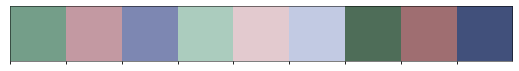

In [26]:
colors = met_brewer.met_brew(name="Monet")
sns.palplot(colors)

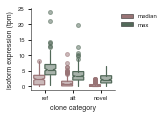

In [27]:
fig = plt.figure(figsize=(1.5, 1.5))

exp_nov_melt["value_log2"] = np.log2(exp_nov_melt["value"]+1)
ax = sns.boxplot(data=exp_nov_melt[exp_nov_melt["variable"].str.contains("dev")], 
                 x="status", y="value", hue="measurement", palette={"median": colors[7],
                                                                    "max": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_xlabel("clone category")
ax.set_ylabel("isoform expression (tpm)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig2/novel_isos.dev_expr_boxplot.pdf", dpi="figure", bbox_inches="tight")

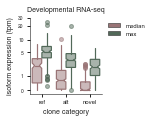

In [28]:
fig = plt.figure(figsize=(1.3, 1.4))

ax = sns.boxplot(data=exp_nov_melt[exp_nov_melt["variable"].str.contains("dev")], 
                 x="status", y="value_log2", hue="measurement", palette={"median": colors[7],
                                                                    "max": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_xlabel("clone category")
ax.set_ylabel("isoform expression (tpm)")

ticks = [0, 1, 5, 10, 20, 30]
ticklabels = [0, 1, 5, 10, 20, 30]
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='y', labelsize=fontsize-2)
plt.title("Developmental RNA-seq")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig2/novel_isos.dev_expr_boxplot.log2.pdf", dpi="figure", bbox_inches="tight")

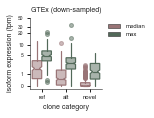

In [29]:
fig = plt.figure(figsize=(1.3, 1.3))

ax = sns.boxplot(data=exp_nov_melt[exp_nov_melt["variable"].str.contains("gtex_ds")], 
                 x="status", y="value_log2", hue="measurement", palette={"median": colors[7],
                                                                    "max": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_xlabel("clone category")
ax.set_ylabel("isoform expression (tpm)")

ticks = [0, 1, 5, 10, 20, 30, 50]
ticklabels = [0, 1, 5, 10, 20, 30, 50]
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='y', labelsize=fontsize-2)
plt.title("GTEx (down-sampled)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig2/novel_isos.gtex_ds_expr_boxplot.log2.pdf", dpi="figure", bbox_inches="tight")

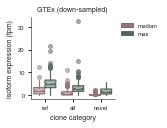

In [30]:
fig = plt.figure(figsize=(1.5, 1.5))

ax = sns.boxplot(data=exp_nov_melt[exp_nov_melt["variable"].str.contains("gtex_ds")], 
                 x="status", y="value", hue="measurement", palette={"median": colors[7],
                                                                    "max": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_xlabel("clone category")
ax.set_ylabel("isoform expression (tpm)")


plt.title("GTEx (down-sampled)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig2/novel_isos.gtex_ds_expr_boxplot.pdf", dpi="figure", bbox_inches="tight")

## 4. distribution of TF families in clone collection and assays v gencode

In [31]:
fam = load_tf_families()

In [32]:
len(genc_tfs)

1635

In [33]:
genc_df = {k: genc_tfs[k].GENCODE_isoforms for k in genc_tfs.keys()}
genc_df = {k: [v.name for v in values] for k, values in genc_df.items()}
genc_df = [(k, v) for k, sublist in genc_df.items() for v in sublist]
genc_df = pd.DataFrame(genc_df, columns=["gene", "isoform"])
genc_df['family'] = genc_df['gene'].map(fam)
genc_df.sample(5)

,gene,isoform,family
390,HOXD3,HOXD3-201,Homeodomain
1761,ZNF33A,ZNF33A-208,C2H2 ZF
1233,DMTF1,DMTF1-213,Myb/SANT
2083,HMGA2,HMGA2-206,AT hook
3804,ZNF671,ZNF671-203,C2H2 ZF


In [34]:
leave_separate = ["C2H2 ZF", "Homeodomain", "bHLH", "Nuclear receptor", "bZIP", "Forkhead", "Ets"]

In [35]:
def rename_family(row):
    if row.family in leave_separate:
        return row.family
    else:
        return "Other"
    
genc_df['family_renamed'] = genc_df.apply(rename_family, axis=1)
genc_df.sample(5)

,gene,isoform,family,family_renamed
1941,SOX6,SOX6-208,HMG/Sox,Other
3201,ZNF230,ZNF230-201,C2H2 ZF,C2H2 ZF
353,TLX2,TLX2-204,Homeodomain,Homeodomain
293,AHCTF1,AHCTF1-202,AT hook,Other
1028,RUNX2,RUNX2-202,Runt,Other


In [36]:
genc_vc = genc_df.groupby("family_renamed")["isoform"].agg("count").reset_index()
genc_vc["source"] = "GENCODE"
genc_vc

,family_renamed,isoform,source
0,C2H2 ZF,1840,GENCODE
1,Ets,89,GENCODE
2,Forkhead,97,GENCODE
3,Homeodomain,350,GENCODE
4,Nuclear receptor,176,GENCODE
5,Other,1179,GENCODE
6,bHLH,264,GENCODE
7,bZIP,149,GENCODE


In [37]:
clone_df = {k: clone_tfs[k].cloned_isoforms for k in clone_tfs.keys()}
clone_df = {k: [v.clone_acc for v in values] for k, values in clone_df.items()}
clone_df = [(k, v) for k, sublist in clone_df.items() for v in sublist]
clone_df = pd.DataFrame(clone_df, columns=["gene", "isoform"])
clone_df['family'] = clone_df['gene'].map(fam)
clone_df.sample(5)

,gene,isoform,family
142,RBPJ,RBPJ|2/4|07B11,CSL
752,HSFY1,HSFY1|1/2|12F03,HSF
166,MSX2,MSX2|2/2|02C09,Homeodomain
372,ZNF143,ZNF143|3/3|09A08,C2H2 ZF
58,RXRG,RXRG|2/2|09F07,Nuclear receptor


In [38]:
def rename_family(row):
    if row.family in leave_separate:
        return row.family
    else:
        return "Other"
    
clone_df['family_renamed'] = clone_df.apply(rename_family, axis=1)

In [39]:
order = clone_df.groupby("family")["isoform"].agg("count").reset_index()
order = order.sort_values(by="isoform", ascending=False)
xorder = list(order["family"])
yvals = list(order["isoform"])

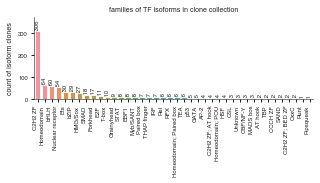

In [40]:
fig = plt.figure(figsize=(5, 1.5))

ax = sns.countplot(data=clone_df, x="family", order=xorder)
ax.set_xlabel("")
ax.set_ylabel("count of isoform clones")
ax.set_title("families of TF isoforms in clone collection")
ax.set_ylim((0, 370))

_= plt.xticks(rotation=90, ha='right')

for i, yval in enumerate(yvals):
    ax.text(i, yval, ' %s' % yval, ha='center', va='bottom', rotation=90, fontsize=6)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
fig.savefig("../../figures/fig2/clone_collection_families.all.pdf", dpi="figure", bbox_inches="tight")

In [41]:
clone_vc = clone_df.groupby("family_renamed")["isoform"].agg("count").reset_index()
clone_vc["source"] = "TFIso1.0"

In [42]:
y1h = load_y1h_pdi_data()
y1h['family'] = y1h['gene_symbol'].map(fam)
y1h['family_renamed'] = y1h.apply(rename_family, axis=1)
y1h.sample(5)

,gene_symbol,clone_acc,HS1006,HS1022,HS1043,HS1067,HS1139,HS1142,HS118,HS1181,...,PF4V1,TNFSF10,TNFSF13,TNFSF14,TNFSF4,TNFSF8,XCL1,XCL2,family,family_renamed
102,PKNOX1,PKNOX1|2/4|06H05,False,False,False,False,True,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Homeodomain,Homeodomain
168,ZNF18,ZNF18|3/3|07D01,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,C2H2 ZF,C2H2 ZF
81,MYF6,MYF6|2/2|03F09,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,bHLH,bHLH
18,EBF3,EBF3|1/3|09A11,False,False,True,False,True,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,EBF1,Other
95,PAX5,PAX5|1/2|08E04,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Paired box,Other


In [43]:
baits = [x for x in y1h.columns if x not in ['gene_symbol', 'clone_acc', 'family', 'family_renamed']]
y1h['any_true'] = y1h[baits].sum(axis=1)
y1h['all_na'] = y1h[baits].isnull().values.all()

# remove any rows with allna values
print(len(y1h))
y1h = y1h[~y1h['all_na']]
print(len(y1h))

189
189


In [44]:
y1h_vc = y1h.groupby("family_renamed")["clone_acc"].agg("count").reset_index()
y1h_vc.columns = ["family_renamed", "isoform"]
y1h_vc["source"] = "Y1H (all)"

In [45]:
y1h_any_vc = y1h[y1h['any_true'] > 0].groupby("family_renamed")["clone_acc"].agg("count").reset_index()
y1h_any_vc.columns = ["family_renamed", "isoform"]
y1h_any_vc["source"] = "Y1H (≥1 PDI)"

In [46]:
y2h = load_y2h_isoform_data(require_at_least_one_ppi_per_isoform=False)
y2h['family'] = y2h['ad_gene_symbol'].map(fam)
y2h['family_renamed'] = y2h.apply(rename_family, axis=1)

# remove any rows with na values
print(len(y2h))
y2h = y2h[~pd.isnull(y2h['Y2H_result'])]
print(len(y2h))

4356
4260


In [47]:
y2h_vc = y2h.groupby("family_renamed")["ad_clone_acc"].agg("count").reset_index()
y2h_vc.columns = ["family_renamed", "isoform"]
y2h_vc["source"] = "Y2H (all)"

In [48]:
y2h_any_vc = y2h[y2h["Y2H_result"] == True].groupby("family_renamed")["ad_clone_acc"].agg("count").reset_index()
y2h_any_vc.columns = ["family_renamed", "isoform"]
y2h_any_vc["source"] = "Y2H (≥1 PPI)"

In [49]:
m1h = load_m1h_activation_data()
m1h['M1H_mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)
m1h['family'] = m1h['gene_symbol'].map(fam)
m1h['family_renamed'] = m1h.apply(rename_family, axis=1)
m1h.sample(5)

,gene_symbol,clone_acc,M1H_rep1,M1H_rep2,M1H_rep3,M1H_mean,family,family_renamed
563,ZNF302,ZNF302|2/5|06B07,-0.116578,-0.504745,-0.645729,-0.422351,C2H2 ZF,C2H2 ZF
179,RARG,RARG|2/2|08C10,2.745829,2.972699,2.820059,2.846196,Nuclear receptor,Nuclear receptor
405,HMG20A,HMG20A|2/2|05C08,0.835396,0.596868,0.667953,0.700072,HMG/Sox,Other
214,TBPL1,TBPL1|2/2|04A07,0.179633,0.217511,0.340948,0.246030,TBP,Other
298,ZNF18,ZNF18|2/3|07H02,2.978433,3.018980,2.950922,2.982778,C2H2 ZF,C2H2 ZF


In [50]:
m1h_vc = m1h.groupby("family_renamed")["clone_acc"].agg("count").reset_index()
m1h_vc.columns = ["family_renamed", "isoform"]
m1h_vc["source"] = "M1H (all)"

In [51]:
m1h_any_vc = m1h[m1h["M1H_mean"].abs() > 1].groupby("family_renamed")["clone_acc"].agg("count").reset_index()
m1h_any_vc.columns = ["family_renamed", "isoform"]
m1h_any_vc["source"] = "M1H (≥2-fold activ.)"

In [52]:
mrg_vc = genc_vc.append(clone_vc)
mrg_vc = mrg_vc.append(y1h_vc).append(y1h_any_vc)
mrg_vc = mrg_vc.append(y2h_vc).append(y2h_any_vc)
mrg_vc = mrg_vc.append(m1h_vc).append(m1h_any_vc)
mrg_vc

,family_renamed,isoform,source
0,C2H2 ZF,1840,GENCODE
1,Ets,89,GENCODE
2,Forkhead,97,GENCODE
3,Homeodomain,350,GENCODE
4,Nuclear receptor,176,GENCODE
...,...,...,...
3,Homeodomain,36,M1H (≥2-fold activ.)
4,Nuclear receptor,32,M1H (≥2-fold activ.)
5,Other,98,M1H (≥2-fold activ.)
6,bHLH,32,M1H (≥2-fold activ.)


In [53]:
mrg_piv = pd.pivot_table(mrg_vc, values="isoform", columns="source", index="family_renamed")
mrg_piv = mrg_piv.fillna(0)
mrg_piv = (mrg_piv/mrg_piv.sum(axis=0))*100
mrg_piv = mrg_piv.T
mrg_piv = mrg_piv.reindex(["GENCODE", "TFIso1.0", "Y1H (all)", "Y1H (≥1 PDI)",
                           "Y2H (all)", "Y2H (≥1 PPI)", "M1H (all)", "M1H (≥2-fold activ.)"])
mrg_piv = mrg_piv.reset_index()

mrg_piv = mrg_piv[["source", "Other", "Ets", "Forkhead", "bZIP", "Nuclear receptor",
                   "bHLH", "Homeodomain", "C2H2 ZF"]]
mrg_piv

family_renamed,source,Other,Ets,Forkhead,bZIP,Nuclear receptor,bHLH,Homeodomain,C2H2 ZF
0,GENCODE,28.450772,2.147683,2.340734,3.595560,4.247104,6.370656,8.445946,44.401544
1,TFIso1.0,25.925926,3.968254,2.248677,3.835979,7.142857,7.936508,8.465608,40.476190
2,Y1H (all),36.507937,3.174603,4.232804,1.058201,11.111111,9.523810,17.989418,16.402116
3,Y1H (≥1 PDI),34.108527,2.325581,3.875969,0.775194,15.503876,9.302326,18.604651,15.503876
4,Y2H (all),13.568075,0.211268,2.112676,3.028169,3.098592,40.774648,12.535211,24.671362
5,Y2H (≥1 PPI),15.216512,0.161878,1.983003,3.278025,3.642250,49.494132,10.926750,15.297450
6,M1H (all),25.562701,3.376206,2.733119,4.019293,7.717042,7.395498,9.324759,39.871383
7,M1H (≥2-fold activ.),26.702997,4.632153,3.269755,4.087193,8.719346,8.719346,9.809264,34.059946


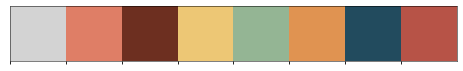

In [54]:
colors = met_brewer.met_brew(name="Hokusai1")
colors.append("lightgrey")
colors = colors[::-1]
#colors[7] = "lightgrey"
sns.palplot(colors)

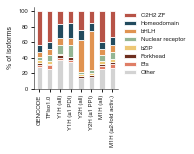

In [55]:
ax = mrg_piv.plot.bar(x="source", stacked=True, color=colors, figsize=(1.5, 1.5))

ax.set_ylabel("% of isoforms")
ax.set_xlabel("")

plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('../../figures/fig2/assay_families.detailed.pdf',
            bbox_inches='tight')

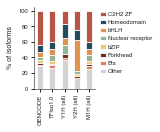

In [56]:
ax = mrg_piv[mrg_piv["source"].isin(["GENCODE", "TFIso1.0", "Y1H (all)",
                  "Y2H (all)", "M1H (all)"])].plot.bar(x="source", stacked=True, color=colors, figsize=(1.1, 1.5))

ax.set_ylabel("% of isoforms")
ax.set_xlabel("")

plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=2, bbox_to_anchor=(1.01, 1), borderpad=0.25,
          handlelength=1, handletextpad=0.2, frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('../../figures/fig2/assay_families.pdf',
            bbox_inches='tight')

## 5. print number of genes/isos in each category for use in schematic figs/text

In [57]:
print("total # of isos in collection")
len(clone_df)

total # of isos in collection


756

In [58]:
print("total # of unique TF genes in collection")
len(clone_df.gene.unique())

total # of unique TF genes in collection


309

In [59]:
print("total # of isos tested in Y1H")
len(y1h)

total # of isos tested in Y1H


189

In [60]:
print("total # of unique TF genes tested in Y1H")
len(y1h.gene_symbol.unique())

total # of unique TF genes tested in Y1H


97

In [61]:
print("total # of baits tested in Y1H")
len(baits)

total # of baits tested in Y1H


191

In [62]:
print("total # of isos with at least 1 interaction in Y1H")
len(y1h[y1h['any_true'] > 0])

total # of isos with at least 1 interaction in Y1H


129

In [63]:
print("total # of unique TF genes with at least 1 interaction in Y1H")
len(y1h[y1h['any_true'] > 0].gene_symbol.unique())

total # of unique TF genes with at least 1 interaction in Y1H


83

In [64]:
print("total # of isos tested in Y2H")
len(y2h.ad_clone_acc.unique())

total # of isos tested in Y2H


255

In [65]:
print("total # of unique TF genes tested in Y2H")
len(y2h.ad_gene_symbol.unique())

total # of unique TF genes tested in Y2H


88

In [66]:
print("total # of partners tested in Y2H")
len(y2h.db_gene_symbol.unique())

total # of partners tested in Y2H


539

In [67]:
print("total # of isos with at least 1 interaction in Y2H")
len(y2h[y2h["Y2H_result"] == True].ad_clone_acc.unique())

total # of isos with at least 1 interaction in Y2H


194

In [68]:
print("total # of unique TF genes with at least 1 interaction in Y2H")
len(y2h[y2h["Y2H_result"] == True].ad_gene_symbol.unique())

total # of unique TF genes with at least 1 interaction in Y2H


88

In [69]:
print("total # of isos tested in M1H")
len(m1h.clone_acc.unique())

total # of isos tested in M1H


622

In [70]:
print("total # of unique TF genes tested in M1H")
len(m1h.gene_symbol.unique())

total # of unique TF genes tested in M1H


264

In [71]:
print("total # of isos with activity in M1H (abs > 1)")
len(m1h[m1h["M1H_mean"].abs() > 1].clone_acc.unique())

total # of isos with activity in M1H (abs > 1)


367

In [72]:
print("total # of unique TF genes with activity in M1H (abs > 1)")
len(m1h[m1h["M1H_mean"].abs() > 1].gene_symbol.unique())

total # of unique TF genes with activity in M1H (abs > 1)


189

In [73]:
all_3 = set(m1h[m1h["M1H_mean"].abs() > 1].gene_symbol.unique()).intersection(set(y2h[y2h["Y2H_result"] == True].ad_gene_symbol.unique())).intersection(set(y1h[y1h['any_true'] > 0].gene_symbol.unique()))
all_3

{'E2F3',
 'ESRRG',
 'FOXJ2',
 'GMEB1',
 'HNF4A',
 'LHX6',
 'LHX9',
 'MEIS1',
 'MEIS2',
 'MEOX1',
 'NFIA',
 'NFIX',
 'NR4A2',
 'PATZ1',
 'PAX5',
 'PBX1',
 'PKNOX1',
 'PPARG',
 'PRRX1',
 'RARG',
 'RBPJ',
 'RFX4',
 'STAT3',
 'TCF12',
 'TCF4',
 'WT1',
 'ZBTB18',
 'ZNF143',
 'ZNF18'}

## 6. compare novel isoform performance in assay to annotated ref/alt

In [74]:
from data_loading import load_valid_isoform_clones

In [75]:
mane_select_clones = {tf.MANE_select_isoform.clone_acc for tf in clone_tfs.values() 
                      if tf.cloned_MANE_select_isoform}

In [76]:
iso = load_valid_isoform_clones()
iso['is_longest_isoform'] = iso['clone_acc'].isin(iso.sort_values('num_aa', 
                                                                  ascending=False).groupby('gene_symbol').nth(0)['clone_acc'].values)
iso['category'] = 'alternative'
iso.loc[iso['clone_acc'].isin(mane_select_clones), 'category'] = 'reference'
iso.loc[iso['is_novel_isoform'], 'category'] = 'novel'

# this df includes some stuff we filtered out - remove these
iso = iso[iso["clone_acc"].isin(clone_df["isoform"])]

In [77]:
len(iso['gene_symbol'].unique())

309

In [78]:
genes_w_ref = list(iso[iso['category'] == 'reference']['gene_symbol'].unique())
len(genes_w_ref)

196

In [79]:
# subset iso df to only genes w MANE select isoform
iso_sub = iso[iso['gene_symbol'].isin(genes_w_ref)]
len(iso_sub)

495

In [80]:
iso_sub['valid_ppi_test'] = iso['clone_acc'].map(y2h.groupby('ad_clone_acc').apply(lambda rows: ((rows['Y2H_result'] == True) |
                                                                                                 (rows['Y2H_result'] == False))
                                                                                                 .any()))

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [81]:
iso_sub['at_least_one_ppi'] = iso['clone_acc'].map(y2h.groupby('ad_clone_acc').apply(lambda rows: ((rows['Y2H_result'] == True))
                                                                                                    .any()))

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
y1h = y1h.drop_duplicates('clone_acc')
iso_sub['at_least_one_pdi'] = iso_sub['clone_acc'].map(y1h.drop(columns=['gene_symbol']).set_index('clone_acc').sum(axis=1) > 0)

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [83]:
iso_sub['at_least_two_fold_activation'] = iso_sub['clone_acc'].map(
                                            m1h.drop(columns=['gene_symbol'])
                                                .set_index('clone_acc')
                                                .mean(axis=1)
                                                .abs() > 1)

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [84]:
iso_sub.category.value_counts()

alternative    209
reference      196
novel           90
Name: category, dtype: int64

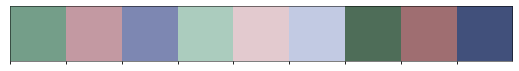

In [85]:
colors = met_brewer.met_brew(name="Monet")
sns.palplot(colors)

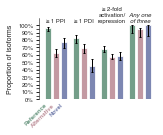

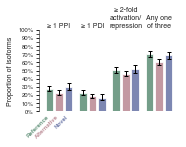

In [86]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2.1, h=1.5)
cats = ['reference', 'alternative', 'novel']
positives = []
tested = []
for cat in cats:
    positives.append(iso_sub.loc[iso_sub['valid_ppi_test'] &
                        (iso_sub['category'] == cat),
                        'at_least_one_ppi'].sum())
    tested.append(iso_sub.loc[iso_sub['valid_ppi_test'] &
                        (iso_sub['category'] == cat),
                        'at_least_one_ppi'].notnull().sum())
for cat in cats:
    positives.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_one_pdi'].sum())
    tested.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_one_pdi'].notnull().sum())
for cat in cats:
    positives.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_two_fold_activation'].sum())
    tested.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_two_fold_activation'].notnull().sum())
for cat in cats:
    tested_iso = (iso_sub['valid_ppi_test'] & 
                    iso_sub['at_least_two_fold_activation'].notnull() &
                    iso_sub['at_least_one_pdi'].notnull() &
                    (iso_sub['category'] == cat))
    positives.append((iso_sub.loc[tested_iso, 'at_least_one_ppi'] |
                 iso_sub.loc[tested_iso, 'at_least_two_fold_activation'] |
                 iso_sub.loc[tested_iso, 'at_least_one_pdi']).sum())
    tested.append(tested_iso.sum())
    
vals = [p / n for p, n in zip(positives, tested)]
#errs = [np.sqrt(((p / n) * (1 - (p / n)) / n)) for p, n in zip(positives, tested)]

pos = np.array(positives)
neg = np.array(tested) - pos
fracs = np.array(vals)
intv = stats.beta.interval(0.6827, pos + 1, neg + 1)
errs = [fracs - intv[0], intv[1] - fracs]
errs[0][pos == 0] = 0.
errs[1][neg == 0] = 0.

offset = 0.5
x_pos = ([i for i in range(3)] + 
       [i + offset for i in range(3, 6)] + 
       [i + offset * 2 for i in range(6, 9)] +
       [i + offset * 3 for i in range(9, 12)])


ax.bar(x=x_pos, height=vals, color=[colors[0], colors[1], colors[2]] * 3)
ax.errorbar(x=x_pos, y=vals, yerr=errs,
            color='black',
            fmt='none',
            linewidth=1,
            capsize=1)
ax.set_ylim(0, 1.1)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 21), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_xticks([0, 1, 2])

ax.set_xticklabels(['Reference', 
                    'Alternative',
                    'Novel'], rotation=45, ha='right', va='top', fontweight='bold')
[t.set_color(colors[i]) for i, t in enumerate(ax.xaxis.get_ticklabels())]

ax.set_ylabel('Proportion of isoforms')
ax.text(y=1.025, x=x_pos[1], s='≥ 1 PPI', 
        fontsize=6,
        va='bottom', ha='center')
ax.text(y=1.025, x=x_pos[4], s='≥ 1 PDI',
        fontsize=6,
        va='bottom', ha='center')
ax.text(y=1.025, x=x_pos[7], s='≥ 2-fold\nactivation/\nrepression',
        fontsize=6, 
        va='bottom', ha='center')
ax.text(y=1.025, x=x_pos[10], s='Any one\nof three', 
        fontsize=6, fontstyle='italic',
        va='bottom', ha='center')
fig.savefig('../../figures/fig2/at-least-some-assay-result_ref-vs-alt-vs-novel_bar.pdf',
            bbox_inches='tight')

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2.5, h=1.5)
cats = ['reference', 'alternative', 'novel']
positives = []
tested = []
for cat in cats:
    positives.append(iso_sub.loc[iso_sub['valid_ppi_test'] &
                        (iso_sub['category'] == cat),
                        'at_least_one_ppi'].sum())

for cat in cats:
    positives.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_one_pdi'].sum())

for cat in cats:
    positives.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_two_fold_activation'].sum())

for cat in cats:
    positives.append((iso_sub.loc[(iso_sub['category'] == cat), 'at_least_one_ppi'].fillna(False) |
                      iso_sub.loc[(iso_sub['category'] == cat), 'at_least_two_fold_activation'].fillna(False) |
                      iso_sub.loc[(iso_sub['category'] == cat), 'at_least_one_pdi'].fillna(False)).sum())    

tested = [(iso_sub['category'] == cat).sum() for cat in cats] * 4
vals = [p / n for p, n in zip(positives, tested)]

pos = np.array(positives)
neg = np.array(tested) - pos
fracs = np.array(vals)
intv = stats.beta.interval(0.6827, pos + 1, neg + 1)
errs = [fracs - intv[0], intv[1] - fracs]
errs[0][pos == 0] = 0.
errs[1][neg == 0] = 0.

offset = 0.5
x_pos = ([i for i in range(3)] + 
       [i + offset for i in range(3, 6)] + 
       [i + offset * 2 for i in range(6, 9)] +
       [i + offset * 3 for i in range(9, 12)])
ax.bar(x=x_pos, height=vals, color=[colors[0], colors[1], colors[2]] * 3)
ax.errorbar(x=x_pos, y=vals, yerr=errs,
            color='black',
            fmt='none',
            capsize=2,
            linewidth=1)
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 21), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_xticks([0, 1, 2])

ax.set_xticklabels(['Reference', 
                    'Alternative',
                    'Novel'], rotation=45, ha='right', va='top', fontweight='bold')
[t.set_color(colors[i]) for i, t in enumerate(ax.xaxis.get_ticklabels())]

ax.set_ylabel('Proportion of isoforms')
ax.text(y=1, x=x_pos[1], s='≥ 1 PPI', 
        fontsize=7,
        va='bottom', ha='center')
ax.text(y=1, x=x_pos[4], s='≥ 1 PDI',
        fontsize=7,
        va='bottom', ha='center')
ax.text(y=1, x=x_pos[7], s='≥ 2-fold\nactivation/\nrepression',
        fontsize=7, 
        va='bottom', ha='center')
ax.text(y=1, x=x_pos[10], s='Any one\nof three', 
        fontsize=7,
        va='bottom', ha='center')
fig.savefig('../../figures/fig2/at-least-some-assay-result_ref-vs-alt-vs-novel_absolute_bar.pdf',
            bbox_inches='tight')

## 7. make validation figures for Y2H (N2H)
## kaia to update the rest of this code when N2H data is moved over
source notebook is n2h_validation.ipynb

In [87]:
df = load_n2h_ppi_validation_data()
print(len(df))
df.head()

821


,test_orf_ida,test_orf_idb,test_pla,test_pos_pair,score_pair,pair,source,test_pos_empty-N1,score_empty-N1,test_pos_empty-N2,score_empty-N2,clone_acc,gene_symbol_tf,gene_symbol_partner,NLR,log2 NLR,score_pair_log10,score_empty-N1_log10,score_empty-N2_log10
0,54731,101256,1,A01,8351.0,54731_101256,vignettes,A03,137.0,A02,501.0,ATF2|2/6|09E05,ATF2,ATF2,16.668663,4.059066,3.921738,2.136721,2.699838
1,12504,101256,1,A04,6709.0,12504_101256,vignettes,A03,137.0,A05,6709.0,ATF2|2/6|09E05,ATF2,FOSL2,1.000000,0.000000,3.826658,2.136721,3.826658
2,10051,101256,1,A06,30279.0,10051_101256,vignettes,A03,137.0,A07,7094.0,ATF2|2/6|09E05,ATF2,MAPK9,4.268255,2.093646,4.481142,2.136721,3.850891
3,12504,101240,1,A11,91959.0,12504_101240,vignettes,A10,158.0,A05,6709.0,CREB5|1/3|08E11,CREB5,FOSL2,13.706812,3.776821,4.963594,2.198657,3.826658
4,5718,101240,1,B03,1071.0,5718_101240,RRS - TF space specific,A10,158.0,B04,391.0,CREB5|1/3|08E11,CREB5,NPPA,2.739130,1.453718,3.029789,2.198657,2.592177


In [88]:
# TODO: remove this once everything finalized 
# (they should already be removed in the table)

# sequence confirmation was done after the expeirment design
# so need to remove sequence failures
y2h = load_full_y2h_data_including_controls()
y2h = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :]
y2h_positives = y2h.loc[y2h['Y2H_result'] == True, ['ad_orf_id', 'db_orf_id']].values
y2h_positives = set(map(tuple, y2h_positives))
y2h_negatives = y2h.loc[y2h['Y2H_result'] == False, ['ad_orf_id', 'db_orf_id']].values
y2h_negatives = set(map(tuple, y2h_negatives))

# check positives / negatives are in Y2H dataset
def in_y2h_positves(row):
    pair = (row['test_orf_idb'],
            row['test_orf_ida'])
    return pair in y2h_positives


def in_y2h_negatives(row):
    pair = (row['test_orf_idb'],
            row['test_orf_ida'])
    return pair in y2h_negatives


df = df.loc[~((df['source'] == 'isoform positives') & 
            ~df.apply(in_y2h_positves, axis=1)), :]
df = df.loc[~((df['source'] == 'isoform negatives') & 
            ~df.apply(in_y2h_negatives, axis=1)), :]
print(len(df))

821


In [89]:
df['source'].value_counts()

RRS - from HuRI               157
isoform positives             131
isoform negatives             131
RRS - hRRS-v2                  78
Lit-BM-13                      75
RRS - TF space specific        71
Lit-BM - TF space specific     62
PRS - hPRS-v2                  60
vignettes                      56
Name: source, dtype: int64

In [90]:
COLOR_LIT = (60 / 255, 134 / 255, 184 / 255)
COLOR_HURI = (155 / 255, 97 / 255, 153 / 255)
colors = {'vignettes': 'yellow', 
          'isoform positives': COLOR_HURI,
          'RRS - TF space specific': 'tab:red',
          'Lit-BM - TF space specific': COLOR_LIT,
          'isoform negatives': 'grey',
          'RRS - from HuRI': 'tab:red',
          'Lit-BM-13': COLOR_LIT,
          'PRS - hPRS-v2': COLOR_LIT,
          'RRS - hRRS-v2': 'tab:red'}

In [91]:
sources = ['PRS - hPRS-v2', 
           'Lit-BM-13', 
           'Lit-BM - TF space specific',
           'RRS - hRRS-v2',
           'RRS - from HuRI', 
           'RRS - TF space specific',
           'isoform positives', 
           'isoform negatives']

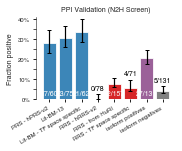

In [92]:
# bar chart
df['result'] = df['NLR'] > df.loc[df['source'] == 'RRS - hRRS-v2', 'NLR'].max()

fig, ax = plt.subplots(1, 1, figsize=(2.5, 1.5))
validation_plot(data=df,
                selections=[df['source'] == x for x in sources],
                labels=[str(x) for x in sources],
                colors=[colors[x] for x in sources],
                result_column='result',
                errorbar_capsize=0.25,
                y_max=0.41,
                xlabel_rotation=90)
ax.set_xticklabels(sources, ha="right", va="top", rotation=30)
ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])
ax.set_title("PPI Validation (N2H Screen)")

for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)

fig.savefig('../../figures/fig2/N2H_barplot.pdf', dpi="figure", bbox_inches='tight')

## 8. make validation figures for Y1H (luciferase)

In [93]:
df = load_PDI_luciferase_validation_experiment()

In [94]:
df['Set'].value_counts()

eY1Hvalidation    141
Name: Set, dtype: int64

In [95]:
print('In PDI validation experiment, tested:')
print(df['gene_symbol'].nunique(), 'different TF genes')
print(df['clone_acc'].nunique(), 'different TF isoforms')
print(df['Bait'].nunique(), 'different baits')
print(df.shape[0], 'total PDIs')

In PDI validation experiment, tested:
19 different TF genes
48 different TF isoforms
41 different baits
141 total PDIs


In [96]:
# update the interaction calls if needed
new_calls = []
for i, row in df.iterrows():
    clone = row.clone_acc
    bait = row.Bait
    orig_y1h_call = row['Interaction?']
    
    try:
        updated_y1h_call = y1h[y1h['clone_acc'] == clone][bait].iloc[0]
    except:
        print("not found: clone: %s | bait: %s | orig call: %s" % (clone, bait, orig_y1h_call))
        updated_y1h_call = np.nan
    new_calls.append(updated_y1h_call)

not found: clone: HNF1B|4/4|05E06 | bait: HS565 | orig call: no
not found: clone: HNF4A|6/6|10F07 | bait: HS1315 | orig call: no
not found: clone: HNF4A|6/6|10F07 | bait: HS20 | orig call: no
not found: clone: LCOR|1/2|09G02 | bait: HS118 | orig call: no
not found: clone: LCOR|1/2|09G02 | bait: HS586 | orig call: no
not found: clone: SOX15|2/2|08F12 | bait: HS1181 | orig call: no
not found: clone: SOX15|2/2|08F12 | bait: HS796 | orig call: no
not found: clone: THRA|3/3|09B09 | bait: HS1185 | orig call: no
not found: clone: THRA|3/3|09B09 | bait: HS204 | orig call: no
not found: clone: HNF1B|4/4|05E06 | bait: HS863 | orig call: yes
not found: clone: LCOR|1/2|09G02 | bait: HS1022 | orig call: yes
not found: clone: TBX6|1/2|03G06 | bait: HS2081 | orig call: yes
not found: clone: TBX6|1/2|03G06 | bait: HS416 | orig call: yes


In [97]:
df["updated_y1h_call"] = new_calls
df.updated_y1h_call.value_counts(dropna=False)

True     67
False    46
NaN      28
Name: updated_y1h_call, dtype: int64

In [98]:
# remove any updated calls that became NaN
df_nn = df[~pd.isnull(df['updated_y1h_call'])]

In [99]:
print('In PDI validation experiment, tested (updated w new calls):')
print(df_nn['gene_symbol'].nunique(), 'different TF genes')
print(df_nn['clone_acc'].nunique(), 'different TF isoforms')
print(df_nn['Bait'].nunique(), 'different baits')
print(df_nn.shape[0], 'total PDIs')

In PDI validation experiment, tested (updated w new calls):
19 different TF genes
42 different TF isoforms
39 different baits
113 total PDIs


In [100]:
print('Isoforms per gene:')
df_nn.groupby(['gene_symbol'])['clone_acc'].nunique().value_counts().sort_index()

Isoforms per gene:


1    4
2    7
3    8
Name: clone_acc, dtype: int64

In [101]:
print('Baits per isoform:')
df_nn.groupby(['clone_acc'])['Bait'].nunique().value_counts().sort_index()

Baits per isoform:


1     5
2    13
3    14
4    10
Name: Bait, dtype: int64

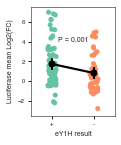

In [102]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=2.)
sns.stripplot(data=df, x='updated_y1h_call', y='Log2(FC)', ax=ax, order=[True, False], 
              palette=sns.color_palette("Set2"), zorder=1)
sns.pointplot(data=df, x='updated_y1h_call', y='Log2(FC)', ax=ax, order=[True, False],
              color='black', zorder=10)
effectsize, pvalue = stats.ttest_ind(df.loc[df['Y1H_positive'], 'Log2(FC)'].values,
                df.loc[~df['Y1H_positive'], 'Log2(FC)'].values)
ax.text(x=0.5, y=4, s='P = {:.1}'.format(pvalue), ha='center')
ax.set_xlabel('eY1H result')
ax.set_xticklabels(['+', '-'])
ax.set_ylabel('Luciferase mean Log2(FC)')
fig.savefig('../../figures/fig2/PDI-luciferase_validation_point-plot.pdf',
            bbox_inches='tight')

In [103]:
df.updated_y1h_call.value_counts()

True     67
False    46
Name: updated_y1h_call, dtype: int64

In [104]:
df.Y1H_positive.value_counts()

True     86
False    55
Name: Y1H_positive, dtype: int64

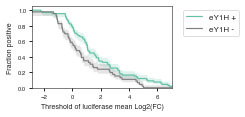

In [105]:
# titration plot of positive vs negative
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2.5, h=1.5)
validation_titration_plot(data=df_nn,
                          selections=[df_nn['updated_y1h_call'], 
                                      ~df_nn['updated_y1h_call']],
                          score_column='Log2(FC)',
                          labels=['eY1H +', 'eY1H -'],
                          colors=[sns.color_palette("Set2")[0], 'grey'],
                          ax=ax)
ax.set_xlabel('Threshold of luciferase mean Log2(FC)')
fig.savefig('../../figures/fig2/PDI-luciferase_validation_titration-plot.pdf',
            bbox_inches='tight')

In [106]:
def p_value(row):
    a = row[['Replicate1', 'Replicate2', 'Replicate3']].values
    b = row['Average (empty-pEZY3-VP160)']
    
    # this code doesn't work on kaia's env; need to update scipy which requires updating to py3.7
    #pval = stats.ttest_1samp(list(a), b, alternative='greater').pvalue
    
    # return two-sided pval * 2 for now
    pval = stats.ttest_1samp(list(a), b).pvalue * 2
    
    return pval

df['p-value'] = df.apply(p_value, axis=1)

In [107]:
df['positive'] = (df['p-value'] < 0.05) & (df['Log2(FC)'] >= 1)

In [108]:
df.groupby('Interaction?')['positive'].mean()

Interaction?
no     0.290909
yes    0.569767
Name: positive, dtype: float64

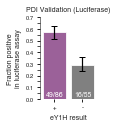

In [109]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1, h=1.5)
validation_plot(data=df,
                selections=[df['Y1H_positive'], 
                           ~df['Y1H_positive']],
                result_column='positive',
                labels=['+', '-'],
                colors=[COLOR_HURI, 'grey'],
                errorbar_capsize=0.25,
                ax=ax)
ax.set_ylim(0, 0.7)
ax.set_xlabel('eY1H result')
ax.set_ylabel('Fraction positive\nin luciferase assay')

ax.set_title("PDI Validation (Luciferase)")

for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)
    
fig.savefig('../../figures/fig2/Luciferase_barplot.pdf', bbox_inches='tight', dpi='figure')

## 9. make reproducibility figure for M1H

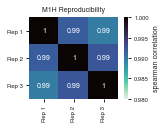

In [110]:
c = m1h[["M1H_rep1", "M1H_rep2", "M1H_rep3"]].corr(method="spearman")


fig = plt.figure(figsize=(2, 1.5))
g = sns.heatmap(c, cmap="mako_r", vmin=0.98, vmax=1, annot=True, cbar_kws={"label": "spearman correlation"})
g.set_yticklabels(["Rep 1", "Rep 2", "Rep 3"])
g.set_xticklabels(["Rep 1", "Rep 2", "Rep 3"], rotation=90, ha="center", va="top")
g.set_title("M1H Reproducibility")

fig.savefig("../../figures/fig2/M1H_heatmap.pdf", bbox_inches="tight", dpi="figure")

## 9. make tables needed for cytoscape network fig

In [111]:
# # table of edges
# #    - clone to (edge + clone_id) + to duplicate
# # table of nodes
# #    - clone to gene
# #    - dna vs isoform vs 

# ppi = load_full_y2h_data_including_controls()
# ppi = ppi.loc[(ppi['category'] == 'tf_isoform_ppis') &
#               (ppi['Y2H_result'] == True),
#               ['ad_clone_acc', 'ad_gene_symbol', 'db_gene_symbol']]
# ppi = ppi.rename(columns={'ad_clone_acc': 'isoform',
#                           'db_gene_symbol': 'partner'})
# ppi['partner'] = ppi['partner'] + '-' + ppi['ad_gene_symbol']
# pdi = pd.read_csv('../../data/internal/a2_juan_pdi_w_unique_isoacc.tsv', sep='\t')
# clones = load_valid_isoform_clones()
# pdi = pdi.loc[pdi['unique_acc'].isin(clones['clone_acc']), :]
# pdi['partner'] = pdi['bait'] + '-' + pdi['tf']
# pdi['isoform'] = pdi['unique_acc']
# edges = pd.concat([ppi.loc[:, ['isoform', 'partner']],
#                    pdi.loc[:, ['isoform', 'partner']]])
# edges.to_csv('../../output/edges.tsv', sep='\t', index=False)

# clones = clones.rename(columns={'clone_acc': 'node_id'})
# clones['type'] = 'isoform'
# dna = pd.DataFrame(data=pdi['partner'].unique(), columns=['node_id'])
# dna['type'] = 'DNA'
# proteins = pd.DataFrame(data=ppi['partner'].unique(), columns=['node_id'])
# proteins['type'] = 'Protein'
# nodes = pd.concat([clones, proteins, dna], sort=True)
# nodes.to_csv('../../output/node_table.tsv', sep='\t', index=False)

## 10. make example expression plot for ZNF414

In [112]:
def developmental_tissue_expression_plot(gene_name, figsize, ylim, means, cols, fig_suffix):
    locs = [x for x in list(means.index) if x.split("|")[0] == gene_name]
    
    # include isos that aren't cloned
    locs = list(set(locs + [x for x in list(means.index) if x.split(" ")[1][:-4] == gene_name]))
    
    n_isos = len(means.loc[locs])
    palette = met_brewer.met_brew(name="Egypt")
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (means.loc[locs, cols]
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    raw_means = 2 ** means.loc[locs, cols] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    axes[0].set_ylabel('log2(tpm + 1)\n')
    axes[0].set_ylim(ylim)
    axes[1].set_ylabel('percent')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0), frameon=False)
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    
    axes[0].spines['top'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    
    plt.subplots_adjust(hspace=0.25)
    plt.savefig('../../figures/fig2/expression_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

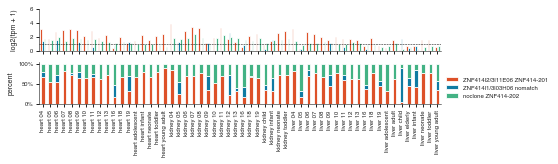

In [113]:
notestis_cols = [x for x in means_dev.columns if "testis" not in x]
notestis_cols = [x for x in notestis_cols if "median" not in x]
notestis_cols = [x for x in notestis_cols if "max" not in x]
notestis_cols = [x for x in notestis_cols if "ovary" not in x]
notestis_cols = [x for x in notestis_cols if "brain" not in x]
developmental_tissue_expression_plot("ZNF414", (7.2, 1.75), (0, 6), means_dev, notestis_cols, 
                                     "means_dev_notestis_large")